# HCP 7T retinotopy data example

This notebook illustrates how to produce flatmaps and 3D WebGPL Viewer using pyCortex and the
HCP 7T retinotopy dataset. I added the Wang-Kastner atlases and resampled eveything to 59k HCP 
standard surfaces. The following folder must be in the pycortex filestore:

.../share/pycortex/db/hcp_999999/atlases/fsaverage_LR59k  
.../share/pycortex/db/hcp_999999/atlases/atlases59k  
.../share/pycortex/db/hcp_999999/atlases/100610

note: In another lane, I am using neuropythy to derive the Benson and Wang-Kastner atlases 
(to start with... (: ) for Polina's data (Leipzig 7T) that has been segmented using Freesurfer. 
I used tksurfer and mris_flatten to create full flat meshes for both hemispheres with some success. 
I am using mri_cor2label to transform the atlases to Freesurfer's labels. To manipulate and 
visusalize the data I am using pyCortex. The goal is to add new subjects from different scanners
to the laminar pipeline in curta, using jupyter notebooks and custom python scripts and to visualize 
them in their native space, independently from the HCP data (which is projected to a common space using
connectome workbench wb_command). Registering new data (e.g. Polina's data) to HCP space is a seconday goal.  
I created this script as a starting point. Just to benchmark the laminar pRF maps using HCP data.
Another goal is to replicate and extend the findings presentd in my cerberal cortex using the whole
HCP 7T retinoropy datset.

@author: nico g
Created on 16.12.2022

In [1]:
%%javascript
function toggler(){
    if(window.alr eady_toggling){
        // Don't add multiple buttons.
        return 0
    }
    let btn = $('.input').append('<button>Toggle Code</button>')
        .children('button');
    btn.on('click', function(e){
        let tgt = e.currentTarget;
        $(tgt).parent().children('.inner_cell').toggle()
    })
    window.already_toggling = true;
}
// Since javascript cells are executed as soon as we load
// the notebook (if it's trusted), and this cell might be at the
// top of the notebook (so is executed first), we need to
// allow time for all of the other code cells to load before
// running. Let's give it 5 seconds.

setTimeout(toggler, 5000);

<IPython.core.display.Javascript object>

/home/nicogravel/anaconda3/envs/py36/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/home/nicogravel/.config/pycortex/options.cfg
/home/nicogravel/anaconda3/envs/py36/share/pycortex/db
0.0
56.061077


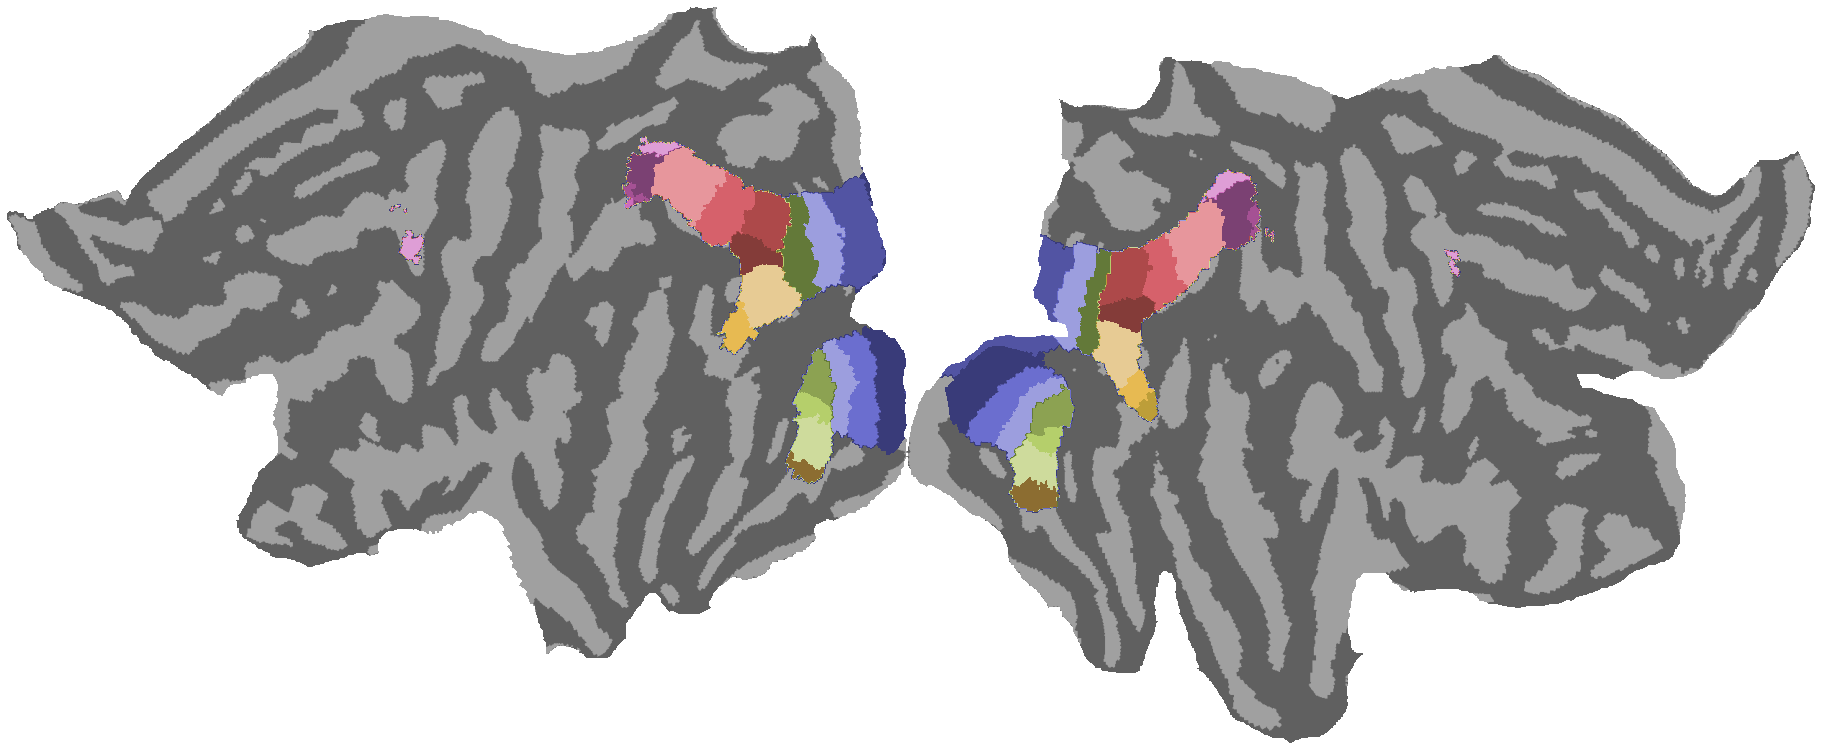

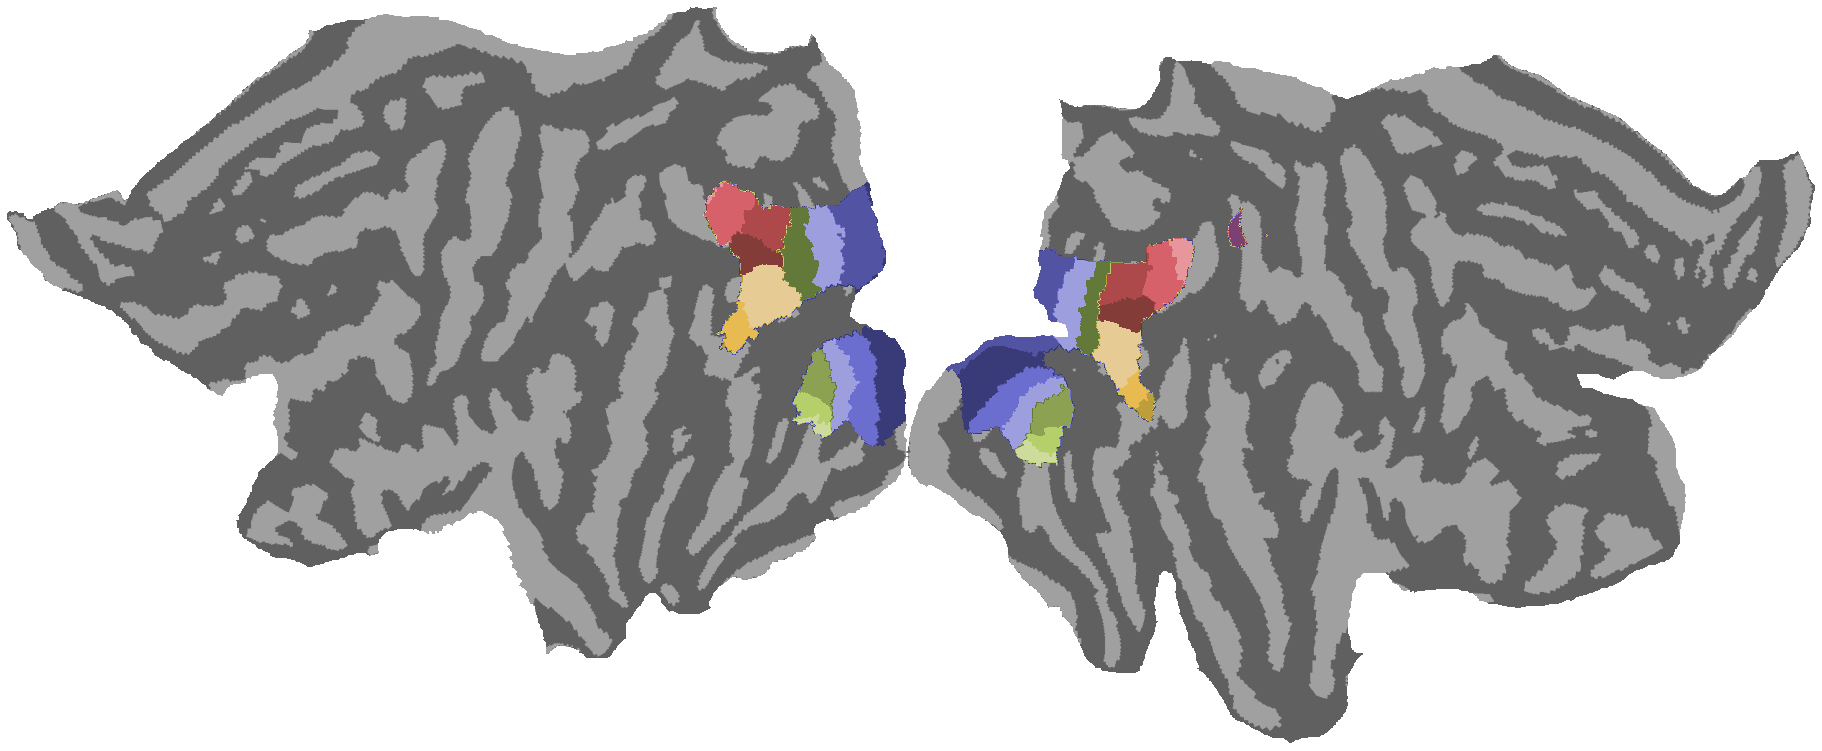

In [1]:
'''
# HCP 7T retinotopy data example

This notebook illustrates how to produce flatmaps and 3D WebGPL Viewer using pyCortex and the
HCP 7T retinotopy dataset. I added the Wang-Kastner atlases and resampled eveything to 59k HCP 
standard surfaces. The following folder must be in the pycortex filestore:

.../share/pycortex/db/hcp_999999/atlases/fsaverage_LR59k  
.../share/pycortex/db/hcp_999999/atlases/atlases59k  
.../share/pycortex/db/hcp_999999/atlases/100610

note: In another lane, I am using neuropythy to derive the Benson and Wang-Kastner atlases 
(to start with... (: ) for Polina's data (Leipzig 7T) that has been segmented using Freesurfer. 
I used tksurfer and mris_flatten to create full flat meshes for both hemispheres with some success. 
I am using mri_cor2label to transform the atlases to Freesurfer's labels. To manipulate and 
visusalize the data I am using pyCortex. The goal is to add new subjects from different scanners
to the laminar pipeline in curta, using jupyter notebooks and custom python scripts and to visualize 
them in their native space, independently from the HCP data (which is projected to a common space using
connectome workbench wb_command). Registering new data (e.g. Polina's data) to HCP space is a seconday goal.  
I created this script as a starting point. Just to benchmark the laminar pRF maps using HCP data.
Another goal is to replicate and extend the findings presentd in my cerberal cortex using the whole
HCP 7T retinoropy datset.



@author: nico g
Created on 16.12.2022
'''

%matplotlib inline

import numpy as np
import nibabel as nb
from matplotlib import pyplot as plt
import nilearn.surface as surface
from matplotlib.colors import ListedColormap
import cortex
import cortex.polyutils
from cortex.options import config
print(cortex.options.usercfg)
print(config.get('basic','filestore'))

# I expect to see RuntimeWarnings in this block
import warnings
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='invalid value encountered in remainder')
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore", category=RuntimeWarning)

    # --------------------------------------------------------------------------------------------------------------------------
# HCP template subject
# note: I used the wonnectome workbench to adapt some atlases. Specifically the following functions:
# wb_command -cifti-separate 
# wb_command -metric-resample
# wb_command -cifti-create-dense-scalar 
#
# you the workbench in the path: 
# echo 'export PATH=$PATH:/Applications/workbench/bin_macosx64' >> ~/.bashrc
# source .bashrc
# ---------------------------------------------------------------------------------------------------------------------------
#folder  = '/Users/nicogravel/piCortex/share/pycortex/db/hcp_999999/atlases'
#folder  = '/home/nicogravel/Laminar_VisualFieldMapping/hcp_999999/atlases'
folder  = '/home/nicogravel/anaconda3/envs/py36/share/pycortex/db/hcp_999999/atlases'
subject = 'hcp_999999'
#bks    = '/Users/nicogravel/piCortex/share/pycortex/db/hcp_999999/surfaces'
#surf   = '/bks/100610.L.very_inflated_1.6mm_MSMAll.59k_fs_LR.surf.gii'



# ---------------------------------------------------------------------------------------------------------------------------
# HCP retinotopic atlases (for 181 subjects)
# ...obtained from the .nii cifti HCP files using nibabel 'load'
# ----------------------------------------------------------------------------------------------------------------------

r2thr = 10
subj  = 2

def surf_data_from_cifti(data, axis, surf_name):
    assert isinstance(axis, nb.cifti2.BrainModelAxis)
    for name, data_indices, model in axis.iter_structures():  # Iterates over volumetric and surface structures
        if name == surf_name:                                 # Just looking for a surface
            data = data.T[data_indices]                       # Assume brainmodels axis is last, move it to front
            vtx_indices = model.vertex                        # Generally 1-N, except medial wall vertices
            surf_data = np.zeros((vtx_indices.max() + 1,) + data.shape[1:], dtype=data.dtype)
            surf_data[vtx_indices] = data
            return surf_data
    raise ValueError(f"No structure named {surf_name}")    

    
# ---------------------------------------------------------------------------------------------------------------------------
# Variance explained
# ---------------------------------------------------------------------------------------------------------------------------
ret_map    = '/fsaverage_LR59k/S1200_7T_Retinotopy181.All.Fit3_R2_MSMAll.59k_fs_LR.dscalar.nii' 
cifti      = nb.load(folder + ret_map)
cifti_data = cifti.get_fdata(dtype=np.float32)

cifti_hdr  = cifti.header
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
map_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
map_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
#rsq_mask = np.hstack((map_lh[:,0], map_rh[:,0]))
rsq_mask  = np.hstack((np.nanmean(map_lh,axis=1), np.nanmean(map_rh,axis=1)))
print(np.nanmin(rsq_mask.flatten()))
print(np.nanmax(rsq_mask.flatten()))


# ---------------------------------------------------------------------------------------------------------------------------
# Wang-Kastner atlas of visual areas + curvature maps
# ...obtained from the .nii cifti HCP files using nibabel 'cifti2'
# ---------------------------------------------------------------------------------------------------------------------------
wang_lh   = '/fsaverage_LR59k/L.wang2015.59k_fs_LR.label.gii'
wang_rh   = '/fsaverage_LR59k/R.wang2015.59k_fs_LR.label.gii'
map_lh    = nb.load(folder + wang_lh).agg_data()
map_rh    = nb.load(folder + wang_rh).agg_data()
both_hemis = np.hstack((map_lh , map_rh))

# Whole atlases
vmax = np.nanmax(both_hemis.flatten())
vmin = np.nanmin(both_hemis.flatten())
cmap = plt.cm.get_cmap('tab20b').copy()
cmap.set_under('k', alpha=0)
vertex = cortex.Vertex(both_hemis, subject, cmap, vmin=vmin+0.0001, vmax=vmax)
cortex.quickshow(vertex , with_rois=False,  with_curvature=True,with_colorbar=False)
plt.show()

# Thresholded by the HCP pRFs variance explained 
vmax = np.nanmax(both_hemis.flatten())
vmin = np.nanmin(both_hemis.flatten())
both_hemis[np.where(rsq_mask<r2thr)]=-1
cmap = plt.cm.get_cmap('tab20b').copy()
cmap.set_under('k', alpha=0)
vertex = cortex.Vertex(both_hemis, subject, cmap, vmin=vmin+0.0001, vmax=vmax)
cortex.quickshow(vertex , with_rois=False,  with_curvature=True,with_colorbar=False)
plt.show()


## Focus on create a good threshold across subjects for the variance explained!

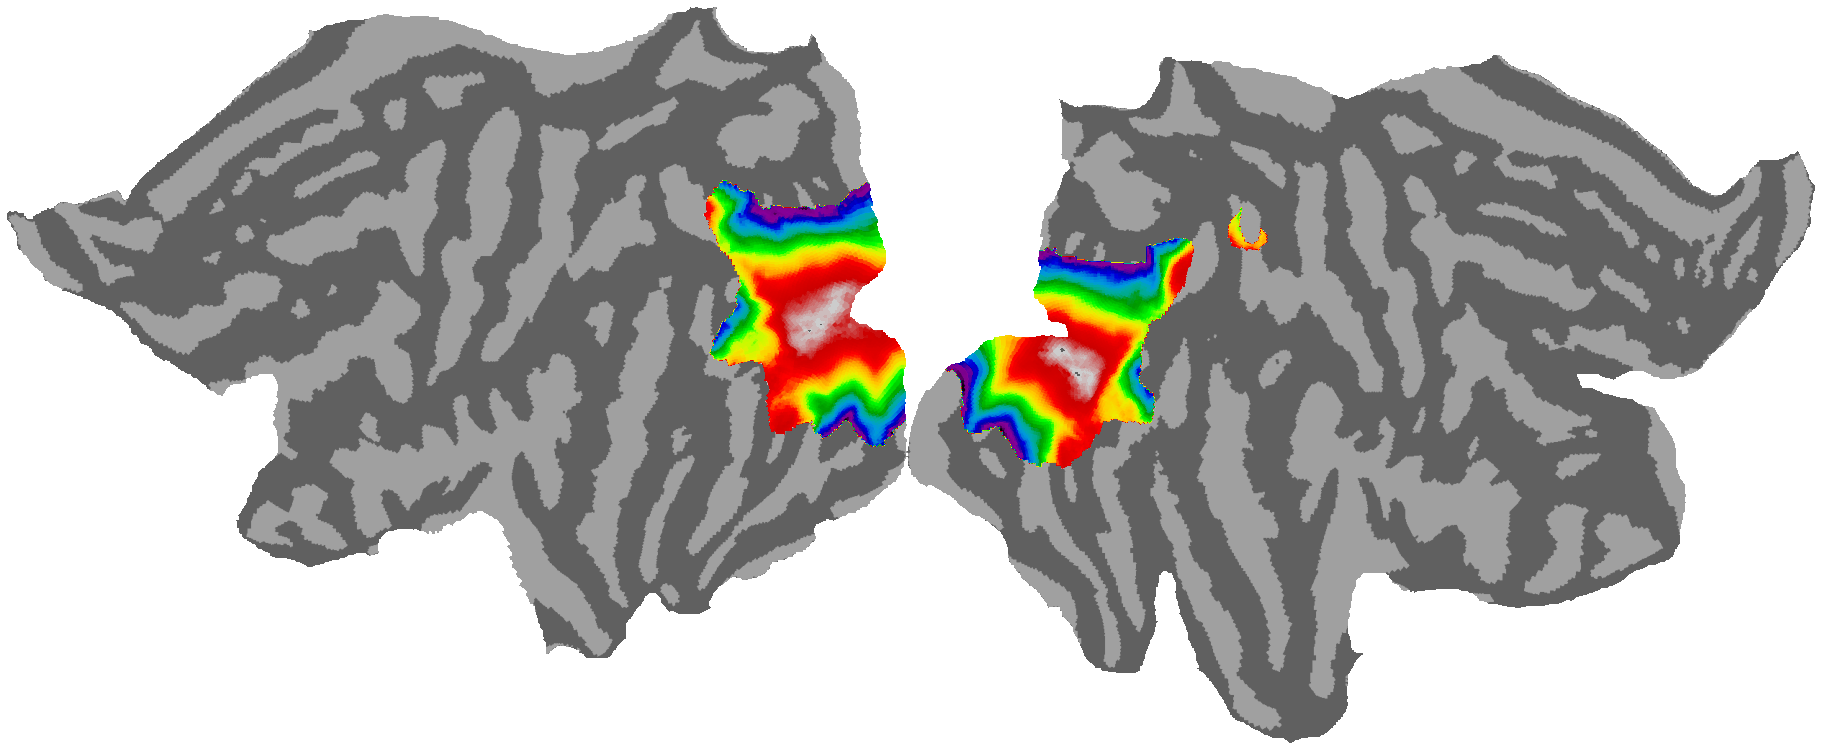

In [2]:
# ---------------------------------------------------------------------------------------------------------------------------
# Eccentricity
# ---------------------------------------------------------------------------------------------------------------------------
ret_map    = '/fsaverage_LR59k/S1200_7T_Retinotopy181.All.Fit3_Eccentricity_MSMAll.59k_fs_LR.dscalar.nii' 
cifti      = nb.load(folder + ret_map)
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr  = cifti.header
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
map_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
map_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
both_hemis = np.hstack((map_lh[:,subj-1], map_rh[:,subj-1]))
both_hemis = np.hstack((np.nanmean(map_lh,axis=1), np.nanmean(map_rh,axis=1)))
both_hemis[np.where(rsq_mask<r2thr)]=np.nan
vmax = np.nanmax(both_hemis.flatten())
vmin = np.nanmin(both_hemis.flatten())
both_hemis[np.where(rsq_mask<r2thr)]=-1
cmap = plt.cm.get_cmap('nipy_spectral_r').copy()
cmap.set_under('k', alpha=0)
vertex = cortex.Vertex(both_hemis, subject, cmap, vmin=vmin+0.01, vmax=vmax)
cortex.quickshow(vertex , with_rois=False,  with_curvature=True,with_colorbar=False)
plt.show()

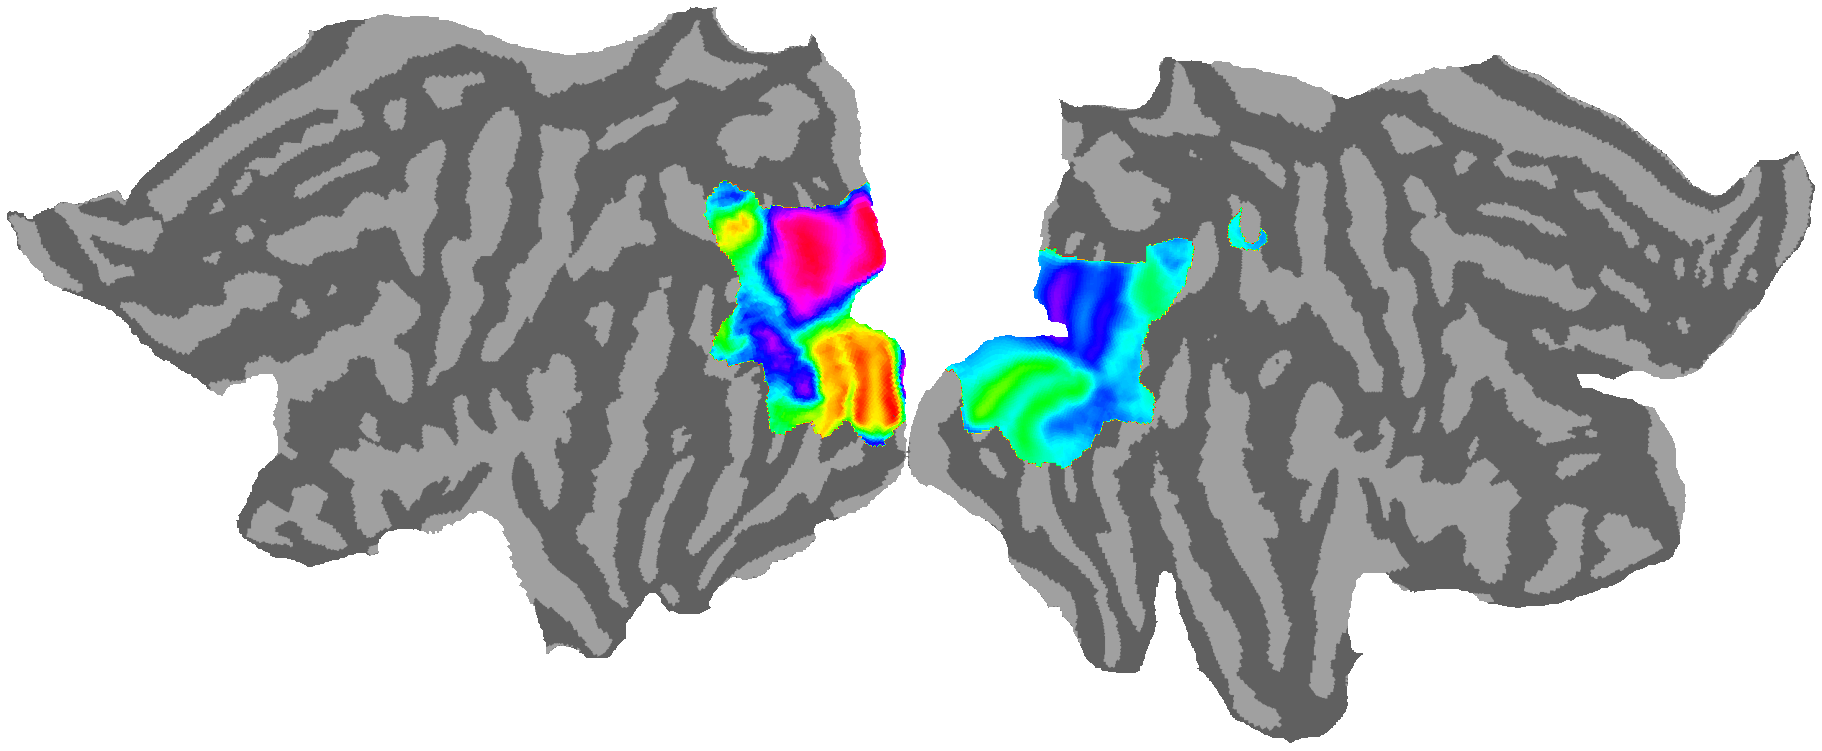

In [6]:
# ---------------------------------------------------------------------------------------------------------------------------
# Polar angle
# ---------------------------------------------------------------------------------------------------------------------------
ret_map    = '/fsaverage_LR59k/S1200_7T_Retinotopy181.All.Fit3_PolarAngle_MSMAll.59k_fs_LR.dscalar.nii' 
cifti      = nb.load(folder + ret_map)
cifti_data = cifti.get_fdata(dtype=np.float32)
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)] 
map_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
map_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
both_hemis = np.hstack((map_lh[:,subj-1], map_rh[:,subj-1]))
both_hemis = np.hstack((np.nanmean(map_lh,axis=1), np.nanmean(map_rh,axis=1)))
both_hemis[np.where(rsq_mask<r2thr)]=np.nan
vmax = np.nanmax(both_hemis.flatten())
vmin = np.nanmin(both_hemis.flatten())
both_hemis[np.where(rsq_mask<r2thr)]=-1
cmap = plt.cm.get_cmap('hsv').copy()
cmap.set_under('k', alpha=0)
vertex = cortex.Vertex(both_hemis, subject,cmap , vmin=vmin+0.0001, vmax=vmax)
cortex.quickshow(vertex , with_rois=False,  with_curvature=True,with_colorbar=False)
plt.show()


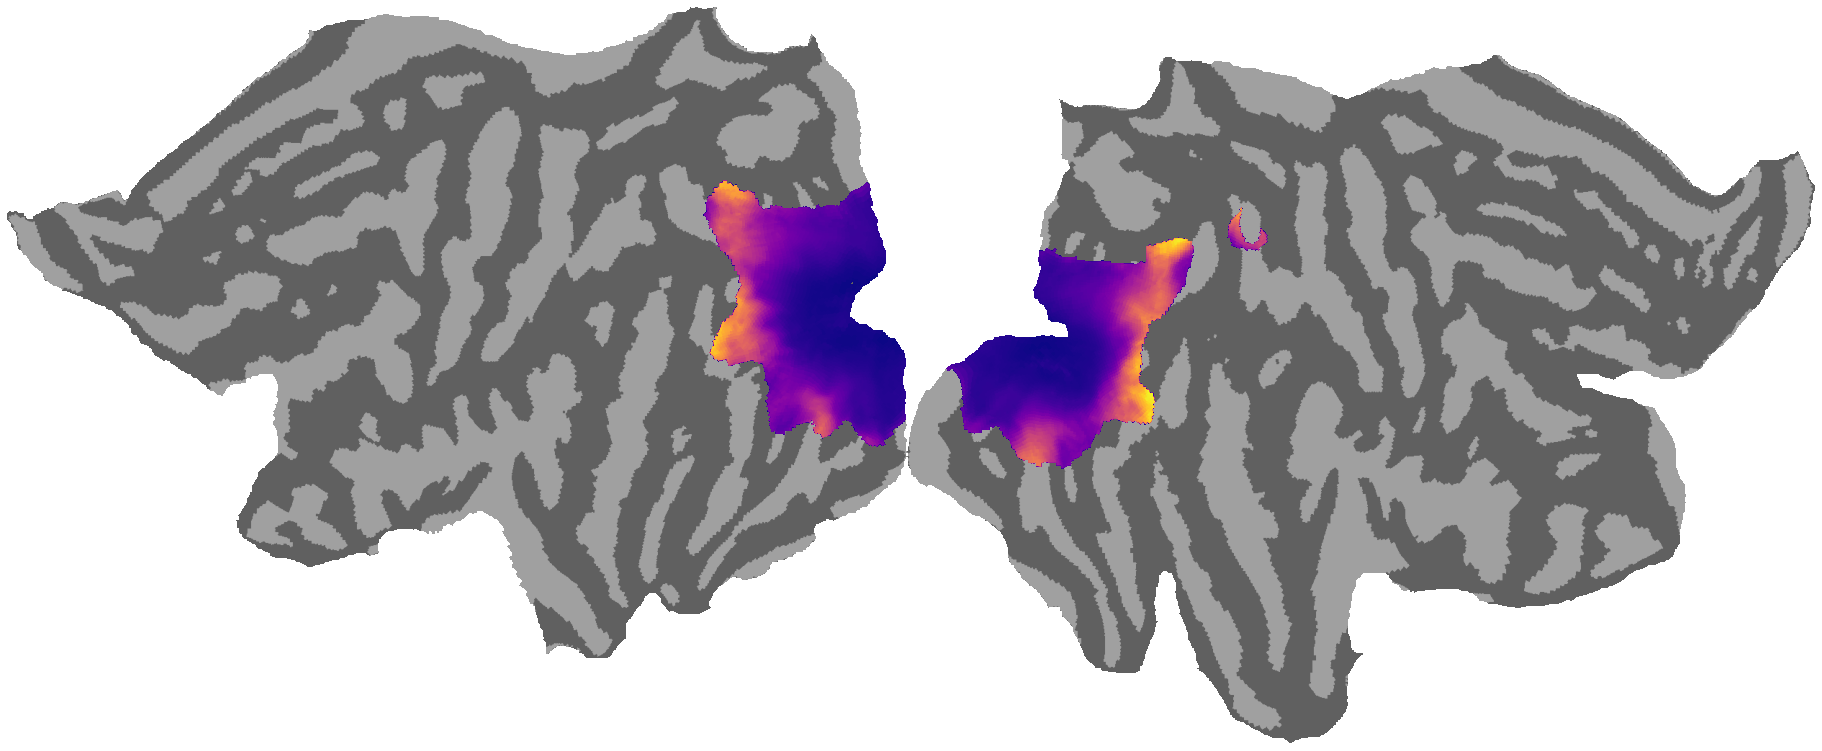

In [4]:
# ---------------------------------------------------------------------------------------------------------------------------
# pRF size
# ---------------------------------------------------------------------------------------------------------------------------
ret_map    = '/fsaverage_LR59k/S1200_7T_Retinotopy181.All.Fit3_ReceptiveFieldSize_MSMAll.59k_fs_LR.dscalar.nii' 
cifti      = nb.load(folder + ret_map)
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr  = cifti.header
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
map_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
map_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
both_hemis = np.hstack((map_lh[:,subj-1], map_rh[:,subj-1]))
both_hemis = np.hstack((np.nanmean(map_lh,axis=1), np.nanmean(map_rh,axis=1)))
both_hemis[np.where(rsq_mask<r2thr)]=np.nan
vmax = np.nanmax(both_hemis.flatten())
vmin = np.nanmin(both_hemis.flatten())
both_hemis[np.where(rsq_mask<r2thr)]=-1
cmap = plt.cm.get_cmap('plasma').copy()
cmap.set_under('k', alpha=0)
vertex = cortex.Vertex(both_hemis, subject,cmap, vmin=vmin+0.0001, vmax=vmax)
cortex.quickshow(vertex , with_rois=False,  with_curvature=True,with_colorbar=False)
plt.show()

#  Visual fields selectivity in V1, V2 and V3 as revealed by the HCP 7T retinotopy dataset  

(118584,)
(118584, 181)


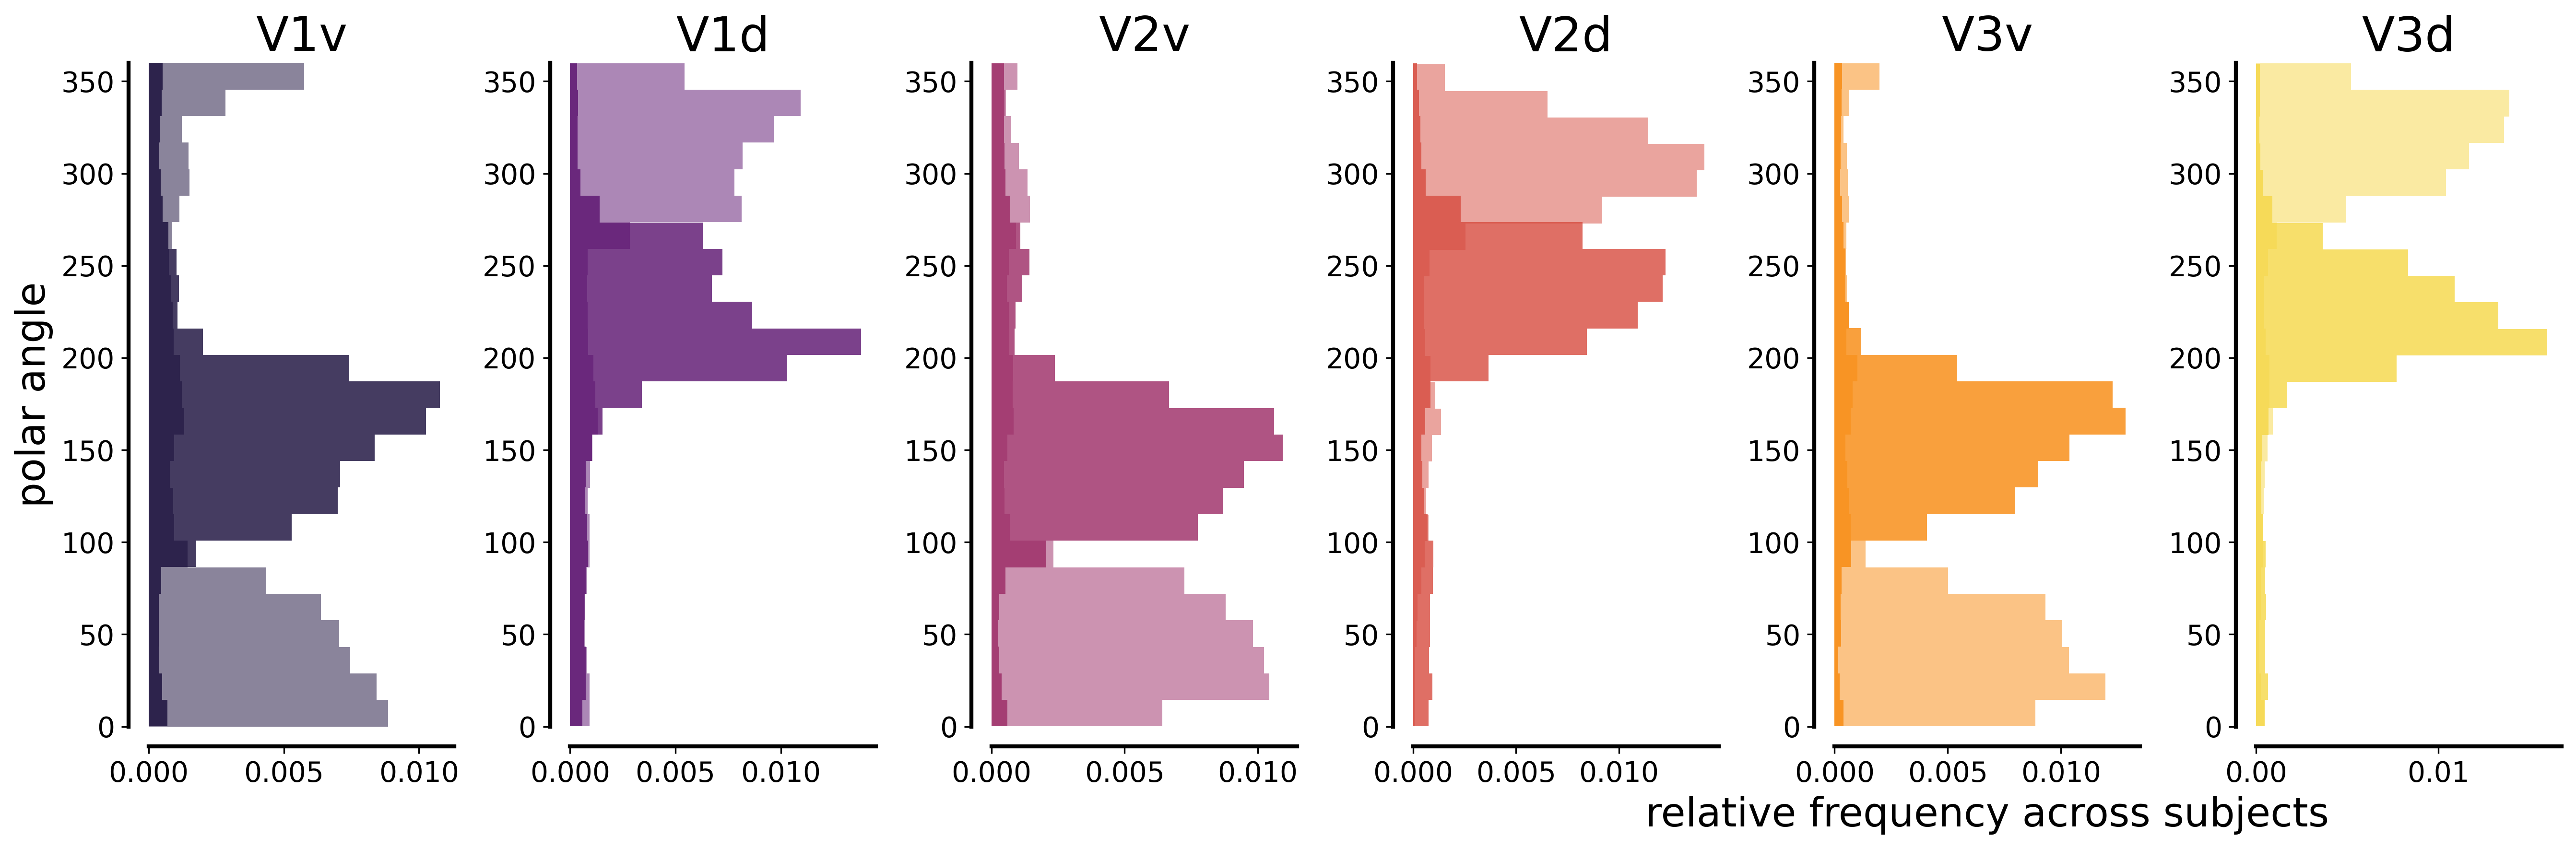

In [7]:
import bottleneck as bn
import seaborn as sns
rois = ["V1v",
           "V1d",
           "V2v", 
           "V2d",
           "V3v",
           "V3d"]
'''
           "hV4",
           "VO1",
           "VO2",
           "PHC1",
           "PHC2",
           "TO2",
           "TO1",
           "LO2",
           "LO1",
           "V3B",
           "V3A",
           "IPS0",
           "IPS1",
           "IPS2",
           "IPS3",
           "IPS4",
           "IPS5",
           "SPL1",
           "FEF"]
'''

#rois = ['V2', 'V3', 'LO1', 'LO2', 'LO3', 'MST', 'MT', 'IPS1', 'FEF']


# Variance explained
# ---------------------------------------------------------------------------------------------------------------------------
ret_map    = '/fsaverage_LR59k/S1200_7T_Retinotopy181.All.Fit3_R2_MSMAll.59k_fs_LR.dscalar.nii' 
cifti      = nb.load(folder + ret_map)
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr  = cifti.header
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
map_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
map_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
rsq_mask = np.hstack((map_lh[:,0], map_rh[:,0]))
rsq_mask = np.nanmean(map_lh[:,0]) %np.hstack((map_lh[:,0], map_rh[:,0]))
#rsq_mask = np.hstack((map_lh[:,0], map_rh[:,0]))
rsq_mask_lh  = np.nanmean(map_lh,axis=1)
rsq_mask_rh  = np.nanmean(map_rh,axis=1)



# Wang
# ---------------------------------------------------------------------------------------------------------------------------
wmap_lh    = nb.load(folder + wang_lh).agg_data()
wmap_rh    = nb.load(folder + wang_rh).agg_data()
both_hemis = np.hstack((wmap_lh , wmap_rh))


print(both_hemis.shape)

# Angle
# ---------------------------------------------------------------------------------------------------------------------------
ret_map    = '/fsaverage_LR59k/S1200_7T_Retinotopy181.All.Fit3_PolarAngle_MSMAll.59k_fs_LR.dscalar.nii' 
cifti      = nb.load(folder + ret_map)
cifti_data = cifti.get_fdata(dtype=np.float32)
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
map_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
map_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
pol_hemis = np.vstack((map_lh, map_rh))

print(pol_hemis.shape)

col = plt.cm.inferno(np.linspace(0.1,0.9,len(rois)))
col[:,-1] = 0.4
alpha_addition_lh = np.zeros(4)
alpha_addition_rh = np.zeros(4)


alpha_addition_lh[-1] = 0.1
alpha_addition_rh[-1] = 0.4

f, ss = plt.subplots(1,len(rois), figsize=(18,6), dpi=300)

for i, roi in enumerate(rois): 
    pol = map_lh[np.where(rsq_mask_lh < r2thr),:]
    pol = map_lh[np.where(wmap_lh == i + 1),:]
    pol = np.squeeze(pol)
    ss[i].hist(pol.flatten(), label='left h.', bins = 25, color=col[i]+alpha_addition_lh, density=True, orientation='horizontal')
    #ss[i].axhline(0, ls='--', c='k')
    #ss[i].axhline(bn.nanmean(pol.flatten()), ls='--', lw=5, c=col[i], dash_capstyle='round')

    ss[i].set_title(roi,fontsize=24)
        
    pol = map_rh[np.where(rsq_mask_rh < r2thr),:]
    pol = map_rh[np.where(wmap_rh == i + 1),:]
    pol = np.squeeze(pol)
    ss[i].hist(pol.flatten(), label='right h.', bins = 25, color=col[i]+alpha_addition_rh, density=True, orientation='horizontal')
    #ss[i].axhline(bn.nanmean(pol.flatten()), ls='--', lw=5, c=col[i]+alpha_addition, dash_capstyle='round')
    
    ss[i].tick_params(axis='y', labelsize = 14)
    ss[i].tick_params(axis='x', labelsize = 14, rotation = 25)
    
    #ss[i].legend(frameon=False, fontsize = 18)
    ss[i].axis(ymin=0,ymax=360)
    plt.setp(ss[i].spines.values(), linewidth=2)
 

ss[0].set_ylabel('polar angle',fontsize=20)
ss[4].set_xlabel('relative frequency across subjects',fontsize=20)
sns.despine(offset=10)
plt.tight_layout()


# Check HCP data download status

In [4]:
import os
fileobj     = open('subj_id.txt')
data        = fileobj.read()
subject_ID  = data.split('\n')
#print('Subjects : ', subject_ID)

task_ID_1  = ['tfMRI_RETBAR1_7T_AP',
              'tfMRI_RETBAR2_7T_PA'
              ]

task_ID_2  = ['tfMRI_MOVIE1_7T_AP',
              'tfMRI_MOVIE2_7T_PA',
              'tfMRI_MOVIE3_7T_PA',
              'tfMRI_MOVIE4_7T_AP', 
             ]

task_ID_3  = ['rfMRI_REST1_7T_PA',
              'rfMRI_REST2_7T_AP',
              'rfMRI_REST3_7T_PA',
              'rfMRI_REST4_7T_AP'
             ]

task_ID = task_ID_1 + task_ID_2 + task_ID_3
print('Number of tasks : ',len(task_ID))

temp_root = '/scratch/nicogravel/HCP_data/temp/'
file      = '_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'

n_subj = 0
x_subj = 0

for subj in range(len(subject_ID)):
    isdir = os.path.isdir(temp_root + subject_ID[subj] + '/')   
    #print(isdir)   
    if isdir == True: 
        folder = temp_root + subject_ID[subj]          
        # get size
        size = 0
        for ele in os.scandir(folder):
            size+=os.path.getsize(ele)
        print('subject: ', subject_ID[subj], ', size(MB): ',  size/1024**2)  
        n_subj = + n_subj + 1
    if isdir == False: 
        x_subj = + x_subj + 1
print('Subject downloaded : ',n_subj, ',  Subject to download : ', x_subj)

n_subj = 0
x_subj = 0

for subj in range(len(subject_ID)):
    isdir = os.path.isdir(temp_root + subject_ID[subj] + '/')   
    #print(isdir)   
    if isdir == True: 
        folder = temp_root + subject_ID[subj]          
        # get size
        size = 0
        for ele in os.scandir(folder):
            size+=os.path.getsize(ele)
        #print('subject: ', subject_ID[subj], ', size(MB): ',  size/1024**2)  
        
        if size/1024**2 > 5000:
            n_subj = + n_subj + 1
    
    if isdir == False: 
        x_subj = + x_subj + 1
        
print('Subjects whith full data : ',n_subj, ',  Subject to download : ', x_subj)

Number of tasks :  10
subject:  100610 , size(MB):  5123.201560974121
subject:  102311 , size(MB):  5123.201560974121
subject:  102816 , size(MB):  5123.201560974121
subject:  104416 , size(MB):  5123.201560974121
subject:  105923 , size(MB):  5123.201560974121
subject:  108323 , size(MB):  5123.201560974121
subject:  109123 , size(MB):  5123.201560974121
subject:  111312 , size(MB):  4536.369209289551
subject:  111514 , size(MB):  5120.202827453613
subject:  114823 , size(MB):  5120.202827453613
subject:  115017 , size(MB):  5120.202827453613
subject:  115825 , size(MB):  5120.202827453613
subject:  116726 , size(MB):  5120.202827453613
subject:  118225 , size(MB):  5120.202827453613
subject:  125525 , size(MB):  5120.202827453613
subject:  126426 , size(MB):  5120.202827453613
subject:  128935 , size(MB):  5120.202827453613
subject:  130518 , size(MB):  5120.202827453613
subject:  131217 , size(MB):  5120.202827453613
subject:  131722 , size(MB):  5120.202827453613
subject:  134627 ,

# Save Wang-Kastner atlas time series

In [31]:
from scipy import stats
import scipy.io as sio
import os.path


folder  = '/home/nicogravel/anaconda3/envs/py36/share/pycortex/db/hcp_999999/atlases'
subject = 'hcp_999999'



rois = ["V1v",
           "V1d",
           "V2v", 
           "V2d",
           "V3v",
           "V3d",
           "hV4",
           "VO1",
           "VO2",
           "PHC1",
           "PHC2",
           "TO2",
           "TO1",
           "LO2",
           "LO1",
           "V3B",
           "V3A",
           "IPS0",
           "IPS1",
           "IPS2",
           "IPS3",
           "IPS4",
           "IPS5",
           "SPL1",
           "FEF"]
#'''

#rois = ['V2', 'V3', 'LO1', 'LO2', 'LO3', 'MST', 'MT', 'IPS1', 'FEF']


# Variance explained
# ---------------------------------------------------------------------------------------------------------------------------
ret_map    = '/fsaverage_LR59k/S1200_7T_Retinotopy181.All.Fit3_R2_MSMAll.59k_fs_LR.dscalar.nii' 
cifti      = nb.load(folder + ret_map)
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr  = cifti.header
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
map_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
map_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
#rsq_mask = np.hstack((map_lh[:,0], map_rh[:,0]))
#rsq_mask = np.nanmean(map_lh[:,0]) %np.hstack((map_lh[:,0], map_rh[:,0]))
#rsq_mask = np.hstack((map_lh[:,0], map_rh[:,0]))
rsq_mask_lh  = np.nanmean(map_lh,axis=1)
rsq_mask_rh  = np.nanmean(map_rh,axis=1)



# Wang
# ---------------------------------------------------------------------------------------------------------------------------
wmap_lh    = nb.load(folder + wang_lh).agg_data()
wmap_rh    = nb.load(folder + wang_rh).agg_data()




# Time series 
# ---------------------------------------------------------------------------------------------------------------------------


fileobj     = open('subj_id.txt')
data        = fileobj.read()
subject_ID  = data.split('\n')
#print(subject_ID)

#import re
bad_subjs = ['111312','126931','132118','901442','973770']
#resultwords  = [word for word in re.split("\W+",query) if word and word.lower() not in stopwords]  # filter out empty words
#result  = [word for word in subject_ID if word.lower() not in bad_subjs]
#subject_ID  = ''.join(str(result))
#print(subject_ID.difference(bad_subjs))

task_ID_1  = ['tfMRI_RETBAR1_7T_AP',
              'tfMRI_RETBAR2_7T_PA'
              ]

task_ID_2  = ['tfMRI_MOVIE1_7T_AP',
              'tfMRI_MOVIE2_7T_PA',
              'tfMRI_MOVIE3_7T_PA',
              'tfMRI_MOVIE4_7T_AP', 
             ]

task_ID_3  = ['rfMRI_REST1_7T_PA',
              'rfMRI_REST2_7T_AP',
              'rfMRI_REST3_7T_PA',
              'rfMRI_REST4_7T_AP'
             ]

task_ID = task_ID_1  + task_ID_2 + task_ID_3
print(len(task_ID))

temp_root = '/scratch/nicogravel/HCP_data/temp/'
file      = '_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'

prep_pth = '/home/nicogravel/Laminar_VisualFieldMapping/HCP_7T_prep/WangKastner/'


# For each 7T HCP retinotopy subject
for subj in range(len(subject_ID)):    
    isdir = os.path.isdir(temp_root + subject_ID[subj] + '/')   
  
    # If there the HCP subject directory has been downloaded...
    if isdir == True:        
        # get size
        size = 0
        for ele in os.scandir( temp_root + subject_ID[subj]    ):
            size+=os.path.getsize(ele)   
        # and if all files are present yet not preprocessed...   
        if size/1024**2 > 5000:        
            isprepdir = os.path.isdir(prep_pth + subject_ID[subj] + '/')         
           
            # Pre-process: divide into foveal and peripheral quarterfields
            if isprepdir == False:           
                os.mkdir(prep_pth + subject_ID[subj])

                for run in range(len(task_ID)):

                    print('Processing data for subject :', subject_ID[subj], 'task :', task_ID[run])
                    temp_save_path = temp_root + subject_ID[subj] + '/' + task_ID[run] + file
                    # Time series
                    cifti      = nb.load(temp_save_path)
                    cifti_data = cifti.get_fdata(dtype=np.float32)
                    cifti_hdr  = cifti.header
                    axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)] 

                    tcourses_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
                    tcourses_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
                    tcourses_lh[np.where(rsq_mask_lh<r2thr),:]=np.nan
                    tcourses_rh[np.where(rsq_mask_rh<r2thr),:]=np.nan
                    print(tcourses_lh.shape)
                    print(tcourses_rh.shape)

                    lh = np.zeros((25,tcourses_lh.shape[1]))
                    rh = np.zeros((25,tcourses_rh.shape[1]))


                    for i, roi in enumerate(rois): 

                        tc_lh = tcourses_lh[np.where(wmap_lh == i + 1),:]
                        tc_lh = np.nanmean(np.squeeze(tc_lh),axis=0)
                        lh[i,:] = stats.zscore(tc_lh)
                        tc_rh = tcourses_rh[np.where(wmap_rh == i + 1),:]
                        tc_rh = np.nanmean(np.squeeze(tc_rh),axis=0)
                        rh[i,:] = stats.zscore(tc_rh)


                    sio.savemat(prep_pth + subject_ID[subj] + '/' + task_ID[run] + '.mat', {'lh': lh, 'rh': rh })





10
Processing data for subject : 134627 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(59292, 300)
(59292, 300)
Processing data for subject : 134627 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(59292, 300)
(59292, 300)
Processing data for subject : 134627 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(59292, 921)
(59292, 921)
Processing data for subject : 134627 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(59292, 918)
(59292, 918)
Processing data for subject : 134627 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(59292, 915)
(59292, 915)
Processing data for subject : 134627 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(59292, 901)
(59292, 901)
Processing data for subject : 134627 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(59292, 900)
(59292, 900)
Processing data for subject : 134627 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(59292, 900)
(59292, 900)
Processing data for subject : 134627 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(59292, 900)
(59292, 900)
Processing data for subject : 134627 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(59292, 900)
(59292, 900)
Processing data for subject : 134829 task : tfMRI_RETBAR1_7T_AP


KeyboardInterrupt: 

# Save V1, V2 and V3 quarter-fields time series

In [ ]:
for i in range(27):
    roi = np.where((wmap_lh==i))
    print(roi[0].shape)
   # print(rois[i])

In [ ]:
from scipy import stats
import scipy.io as sio
import os.path

folder  = '/home/nicogravel/anaconda3/envs/py36/share/pycortex/db/hcp_999999/atlases'
subject = 'hcp_999999'

rois = ["V1v",
           "V1d",
           "V2v", 
           "V2d",
           "V3v",
           "V3d"]

'''
           "hV4",
           "VO1",
           "VO2",
           "PHC1",
           "PHC2",
           "TO2",
           "TO1",
           "LO2",
           "LO1",
           "V3B",
           "V3A",
           "IPS0",
           "IPS1",
           "IPS2",
           "IPS3",
           "IPS4",
           "IPS5",
           "SPL1",
           "FEF"]
'''

#rois = ['V2', 'V3', 'LO1', 'LO2', 'LO3', 'MST', 'MT', 'IPS1', 'FEF']


# Variance explained
# ---------------------------------------------------------------------------------------------------------------------------
ret_map    = '/fsaverage_LR59k/S1200_7T_Retinotopy181.All.Fit3_R2_MSMAll.59k_fs_LR.dscalar.nii' 
cifti      = nb.load(folder + ret_map)
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr  = cifti.header
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
map_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
map_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
rsq_mask_lh  = np.nanmean(map_lh,axis=1)
rsq_mask_rh  = np.nanmean(map_rh,axis=1)

# Eccentricity
# ---------------------------------------------------------------------------------------------------------------------------
ret_map    = '/fsaverage_LR59k/S1200_7T_Retinotopy181.All.Fit3_Eccentricity_MSMAll.59k_fs_LR.dscalar.nii' 
cifti      = nb.load(folder + ret_map)
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr  = cifti.header
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
map_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
map_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
ecc_lh  = np.nanmean(map_lh,axis=1)
ecc_rh  = np.nanmean(map_rh,axis=1)

# Angle
# ---------------------------------------------------------------------------------------------------------------------------
ret_map    = '/fsaverage_LR59k/S1200_7T_Retinotopy181.All.Fit3_PolarAngle_MSMAll.59k_fs_LR.dscalar.nii' 
cifti      = nb.load(folder + ret_map)
cifti_data = cifti.get_fdata(dtype=np.float32)
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
map_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
map_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')
pol_lh  = np.nanmean(map_lh,axis=1)
pol_rh  = np.nanmean(map_rh,axis=1)

# Wang
# ---------------------------------------------------------------------------------------------------------------------------
wmap_lh    = nb.load(folder + wang_lh).agg_data()
wmap_rh    = nb.load(folder + wang_rh).agg_data()



# Time series 
# ---------------------------------------------------------------------------------------------------------------------------
fileobj     = open('subj_id.txt')
data        = fileobj.read()
subject_ID  = data.split('\n')


task_ID_1  = ['tfMRI_RETBAR1_7T_AP',
              'tfMRI_RETBAR2_7T_PA'
              ]

task_ID_2  = ['tfMRI_MOVIE1_7T_AP',
              'tfMRI_MOVIE2_7T_PA',
              'tfMRI_MOVIE3_7T_PA',
              'tfMRI_MOVIE4_7T_AP', 
             ]

task_ID_3  = ['rfMRI_REST1_7T_PA',
              'rfMRI_REST2_7T_AP',
              'rfMRI_REST3_7T_PA',
              'rfMRI_REST4_7T_AP'
             ]

task_ID = task_ID_1  + task_ID_2 + task_ID_3

temp_root = '/scratch/nicogravel/HCP_data/temp/'
file      = '_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'

#prep_pth = '/home/nicogravel/Laminar_VisualFieldMapping/HCP_7T_prep/WangKastner/'
prep_pth = '/home/nicogravel/Laminar_VisualFieldMapping/HCP_7T_prep/EVC/'

eccBin = 2
eccMin = 0
eccMax = 6
sigMax = 6
v1v2v3 = {1: 'V1', 3: 'V2', 5: 'V3'}


n_subj = 0
x_subj = 0


# For each 7T HCP retinotopy subject
for subj in range(len(subject_ID)):    
    isdir = os.path.isdir(temp_root + subject_ID[subj] + '/')   
  
    # If there the HCP subject directory has been downloaded...
    if isdir == True:        
        # get size
        size = 0
        for ele in os.scandir( temp_root + subject_ID[subj]    ):
            size+=os.path.getsize(ele)   
        # and if all files are present yet not preprocessed...   
        if size/1024**2 > 5000:
            n_subj = + n_subj + 1
            isprepdir = os.path.isdir(prep_pth + subject_ID[subj] + '/')         
           
            # Pre-process: divide into foveal and peripheral quarterfields
            if isprepdir == False:
                x_subj = + x_subj + 1
                print('Subjects preprocessed : ',n_subj, ',  Subject to preprocess : ', x_subj)
                os.mkdir(prep_pth + subject_ID[subj])
                for run in range(len(task_ID)):
                    print('Processing data for subject :', subject_ID[subj], 'task :', task_ID[run])
                    temp_save_path = temp_root + subject_ID[subj] + '/' + task_ID[run] + file
                    # Time series
                    cifti      = nb.load(temp_save_path)
                    cifti_data = cifti.get_fdata(dtype=np.float32)
                    cifti_hdr  = cifti.header
                    axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)] 

                    tcourses_lh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT')
                    tcourses_rh = surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_RIGHT')

                    tcourses_lh[np.where(rsq_mask_lh<r2thr),:]=np.nan
                    tcourses_rh[np.where(rsq_mask_rh<r2thr),:]=np.nan


                    data_lh = np.zeros((3,4,tcourses_lh.shape[1]))
                    data_rh = np.zeros((3,4,tcourses_rh.shape[1]))
                    # lf, lp, uf, up
                    c = -1
                    for i in v1v2v3: 
                       
                        c = c + 1
                        
                       

                        # Left hemisphere
                        
                        print(rois[i-1])
                        # ventral: upper-fovea 
                        tc = tcourses_lh[np.where((wmap_lh == i ) & \
                                            (pol_lh > 0) & (pol_lh < 90) & \
                                            (ecc_lh > eccMin) & (ecc_lh < eccBin)),:]
                        print(tc.shape)
                        data_lh[c,0,:]  = stats.zscore(np.nanmean(np.squeeze(tc),axis=0))
                       
                        # ventral: upper-parafovea 
                        tc = tcourses_lh[np.where((wmap_lh == i ) & \
                                            (pol_lh > 0) & (pol_lh < 90) & \
                                            (ecc_lh > eccBin) & (ecc_lh < eccMax)),:]
                        print(tc.shape)
                        data_lh[c,1,:] = stats.zscore(np.nanmean(np.squeeze(tc),axis=0))

                        print(rois[i])
                        # dorsal: lower-fovea 
                        tc = tcourses_lh[np.where((wmap_lh == i + 1) & \
                                            (pol_lh > 270) & (pol_lh < 360) & \
                                            (ecc_lh > eccMin) & (ecc_lh < eccBin)),:]
                        print(tc.shape)
                        data_lh[c,2,:] = stats.zscore(np.nanmean(np.squeeze(tc),axis=0))

                        # dorsal: lower-parafovea 
                        tc = tcourses_lh[np.where((wmap_lh == i + 1) & \
                                            (pol_lh > 270) & (pol_lh < 360) & \
                                            (ecc_lh > eccBin) & (ecc_lh < eccMax)),:]
                        print(tc.shape)
                        data_lh[c,3,:] = stats.zscore(np.nanmean(np.squeeze(tc),axis=0))

                        # Right hemisphere
                        
                        # ventral: upper-fovea 
                        tc = tcourses_rh[np.where((wmap_rh == i ) & \
                                            (pol_rh > 90) & (pol_rh < 180) & \
                                            (ecc_rh > eccMin) & (ecc_rh < eccBin)),:]
                        data_rh[c,0,:] = stats.zscore(np.nanmean(np.squeeze(tc),axis=0))

                        # ventral: upper-parafovea 
                        tc = tcourses_rh[np.where((wmap_rh == i ) & \
                                            (pol_rh > 90) & (pol_rh < 180) & \
                                            (ecc_rh > eccBin) & (ecc_rh < eccMax)),:]
                        data_rh[c,1,:] = stats.zscore(np.nanmean(np.squeeze(tc),axis=0))
                        
                        # dorsal: lower-fovea 
                        tc = tcourses_rh[np.where((wmap_rh == i + 1) & \
                                            (pol_rh > 180) & (pol_rh < 270) & \
                                            (ecc_rh > eccMin) & (ecc_rh < eccBin)),:]
                        data_rh[c,2,:] = stats.zscore(np.nanmean(np.squeeze(tc),axis=0))

                        # dorsal: lower-parafovea 
                        tc = tcourses_rh[np.where((wmap_rh == i + 1) & \
                                            (pol_rh > 180) & (pol_rh < 270) & \
                                            (ecc_rh > eccBin) & (ecc_rh < eccMax)),:]
                        data_rh[c,3,:] = stats.zscore(np.nanmean(np.squeeze(tc),axis=0))





                    # Save the preprocessed data:
                    sio.savemat(prep_pth + subject_ID[subj] + '/' + task_ID[run] + '_ecv24rois.mat', {'data_lh': data_lh, 'data_rh': data_rh})






Processing data for subject : 191033 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 191033 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 191033 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 191033 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 191033 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 191033 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 191033 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191033 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191033 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191033 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191336 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 191336 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 191336 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 191336 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 191336 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 191336 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 191336 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191336 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191336 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191336 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191841 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 191841 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 191841 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 191841 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 191841 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 191841 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 191841 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191841 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191841 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 191841 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 192439 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 192439 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 192439 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 192439 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 192439 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 192439 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 192439 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 192439 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 192439 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 192439 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 192641 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 192641 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 192641 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 192641 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 192641 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 192641 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 192641 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 192641 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 192641 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 192641 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 193845 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 193845 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 193845 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 193845 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 193845 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 193845 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 193845 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 193845 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 193845 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 193845 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 195041 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 195041 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 195041 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 195041 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 195041 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 195041 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 195041 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 195041 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 195041 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 195041 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 196144 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 196144 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 196144 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 196144 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 196144 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 196144 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 196144 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 196144 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 196144 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 196144 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 197348 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 197348 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 197348 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 197348 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 197348 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 197348 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 197348 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 197348 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 197348 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 197348 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 198653 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 198653 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 198653 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 198653 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 198653 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 198653 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 198653 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 198653 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 198653 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 198653 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 199655 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 199655 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 199655 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 199655 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 199655 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 199655 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 199655 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 199655 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 199655 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 199655 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200210 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 200210 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 200210 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 200210 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 200210 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 200210 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200210 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200210 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200210 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200311 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 200311 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 200311 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 200311 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 200311 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 200311 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 200311 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200311 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200311 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200311 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200614 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 200614 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 200614 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 200614 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 200614 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 200614 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 200614 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200614 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200614 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 200614 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 201515 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 201515 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 201515 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 201515 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 201515 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 201515 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 201515 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 201515 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 201515 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 201515 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 203418 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 203418 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 203418 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 203418 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 203418 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 203418 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 203418 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 203418 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 203418 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 203418 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 204521 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 204521 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 204521 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 204521 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 204521 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 204521 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 204521 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 204521 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 204521 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 204521 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 205220 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 205220 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 205220 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 205220 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 205220 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 205220 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 205220 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 205220 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 205220 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 205220 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 209228 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 209228 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 209228 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 209228 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 209228 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 209228 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 209228 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 209228 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 209228 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 209228 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 212419 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 212419 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 212419 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 212419 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 212419 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 212419 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 212419 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 212419 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 212419 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 212419 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 214019 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 214019 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 214019 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 214019 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 214019 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 214019 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 214019 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 214019 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 214019 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 214019 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 214524 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 214524 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 214524 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 214524 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 214524 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 214524 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 214524 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 214524 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 214524 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 214524 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 221319 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 221319 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 221319 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 221319 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 221319 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 221319 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 221319 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 221319 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 221319 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 221319 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 233326 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 233326 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 233326 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 233326 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 233326 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 233326 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 233326 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 233326 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 233326 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 233326 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 239136 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 239136 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 239136 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 239136 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 239136 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 239136 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 239136 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 239136 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 239136 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 239136 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 246133 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 246133 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 246133 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 246133 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 246133 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 246133 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 246133 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 246133 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 246133 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 246133 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 249947 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 249947 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 249947 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 249947 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 249947 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 249947 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 249947 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 249947 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 249947 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 249947 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 251833 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 251833 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 251833 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 251833 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 251833 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 251833 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 251833 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 251833 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 251833 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 251833 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 257845 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 257845 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 257845 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 257845 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 257845 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 257845 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 257845 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 257845 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 257845 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 257845 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 263436 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 263436 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 263436 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 263436 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 263436 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 263436 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 263436 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 263436 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 263436 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 263436 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 283543 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 283543 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 283543 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 283543 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 283543 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 283543 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 283543 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 283543 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 283543 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 283543 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 318637 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 318637 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 318637 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 318637 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 318637 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 318637 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 318637 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 318637 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 318637 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 318637 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 320826 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 320826 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 320826 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 320826 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 320826 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 320826 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 320826 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 320826 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 320826 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 320826 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 330324 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 330324 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 330324 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 330324 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 330324 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 330324 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 330324 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 330324 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 330324 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 330324 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 346137 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 346137 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 346137 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 346137 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 346137 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 346137 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 346137 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 346137 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 346137 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 346137 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 352738 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 352738 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 352738 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 352738 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 352738 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 352738 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 352738 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 352738 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 352738 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 352738 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 360030 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 360030 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 360030 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 360030 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 360030 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 360030 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 360030 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 360030 task : rfMRI_REST2_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 360030 task : rfMRI_REST3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 360030 task : rfMRI_REST4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 900)
(1, 91, 900)
V1d
(1, 53, 900)
(1, 113, 900)
V2v
(1, 83, 900)
(1, 122, 900)
V2d
(1, 53, 900)
(1, 91, 900)
V3v
(1, 55, 900)
(1, 95, 900)
V3d
(1, 76, 900)
(1, 102, 900)
Processing data for subject : 365343 task : tfMRI_RETBAR1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 365343 task : tfMRI_RETBAR2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 300)
(1, 91, 300)
V1d
(1, 53, 300)
(1, 113, 300)
V2v
(1, 83, 300)
(1, 122, 300)
V2d
(1, 53, 300)
(1, 91, 300)
V3v
(1, 55, 300)
(1, 95, 300)
V3d
(1, 76, 300)
(1, 102, 300)
Processing data for subject : 365343 task : tfMRI_MOVIE1_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 921)
(1, 91, 921)
V1d
(1, 53, 921)
(1, 113, 921)
V2v
(1, 83, 921)
(1, 122, 921)
V2d
(1, 53, 921)
(1, 91, 921)
V3v
(1, 55, 921)
(1, 95, 921)
V3d
(1, 76, 921)
(1, 102, 921)
Processing data for subject : 365343 task : tfMRI_MOVIE2_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 918)
(1, 91, 918)
V1d
(1, 53, 918)
(1, 113, 918)
V2v
(1, 83, 918)
(1, 122, 918)
V2d
(1, 53, 918)
(1, 91, 918)
V3v
(1, 55, 918)
(1, 95, 918)
V3d
(1, 76, 918)
(1, 102, 918)
Processing data for subject : 365343 task : tfMRI_MOVIE3_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 915)
(1, 91, 915)
V1d
(1, 53, 915)
(1, 113, 915)
V2v
(1, 83, 915)
(1, 122, 915)
V2d
(1, 53, 915)
(1, 91, 915)
V3v
(1, 55, 915)
(1, 95, 915)
V3d
(1, 76, 915)
(1, 102, 915)
Processing data for subject : 365343 task : tfMRI_MOVIE4_7T_AP


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


V1v
(1, 53, 901)
(1, 91, 901)
V1d
(1, 53, 901)
(1, 113, 901)
V2v
(1, 83, 901)
(1, 122, 901)
V2d
(1, 53, 901)
(1, 91, 901)
V3v
(1, 55, 901)
(1, 95, 901)
V3d
(1, 76, 901)
(1, 102, 901)
Processing data for subject : 365343 task : rfMRI_REST1_7T_PA


pixdim[1,2,3] should be non-zero; setting 0 dims to 1
